In [13]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [14]:
data = pd.read_csv('Airline-passengers.csv')
data = data.dropna()
data['lnair'] = np.log(data['Passengers'])
data

,Month,Passengers,lnair
0,1949-01,112,4.718499
1,1949-02,118,4.770685
2,1949-03,132,4.882802
3,1949-04,129,4.859812
4,1949-05,121,4.795791
...,...,...,...
139,1960-08,606,6.406880
140,1960-09,508,6.230481
141,1960-10,461,6.133398
142,1960-11,390,5.966147


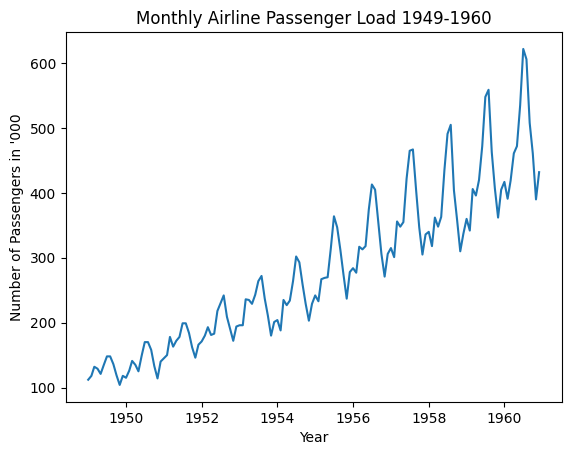

In [15]:
dataframe = pd.DataFrame(data, columns=['Month', 'Passengers'])
#changing the datatype
dataframe['Month'] = dataframe['Month'].astype('datetime64[ns]')
#setting the date as index
dataframe = dataframe.set_index('Month')
dataframe

#plot
plt.plot(dataframe['Passengers'], marker = '')

plt.xlabel('Year')
plt.ylabel("Number of Passengers in '000")
plt.title('Monthly Airline Passenger Load 1949-1960')

plt.show()

# There appears to be a 12-month seasonality

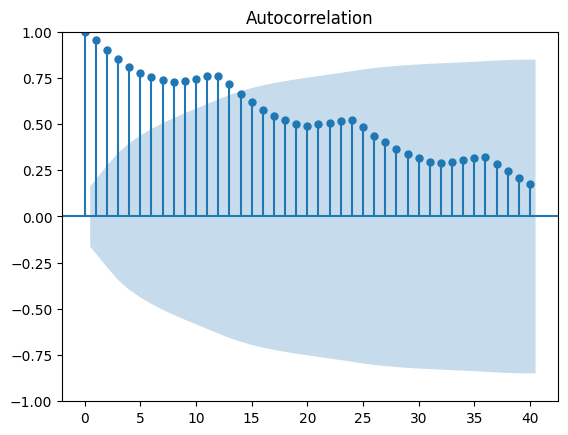

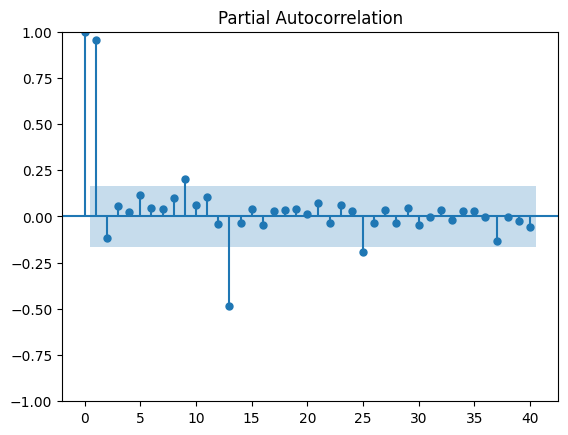

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['lnair'], lags = 40)
plot_pacf(data['lnair'], method='ywm', lags = 40);

In [17]:
lnair12 = data['lnair'] - data['lnair'].shift(12)
lnair12.head(20)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12    0.026433
13    0.065597
14    0.065958
15    0.045462
16    0.032523
17    0.098672
18    0.138586
19    0.138586
Name: lnair, dtype: float64

In [18]:
data['lnair12'] = lnair12
data

,Month,Passengers,lnair,lnair12
0,1949-01,112,4.718499,NaN
1,1949-02,118,4.770685,NaN
2,1949-03,132,4.882802,NaN
3,1949-04,129,4.859812,NaN
4,1949-05,121,4.795791,NaN
...,...,...,...,...
139,1960-08,606,6.406880,0.080731
140,1960-09,508,6.230481,0.092754
141,1960-10,461,6.133398,0.124585
142,1960-11,390,5.966147,0.074503


Airline Passenger Load - Seasonal Differencing


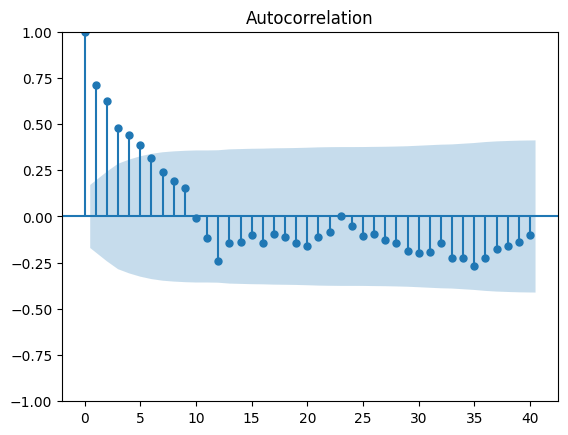

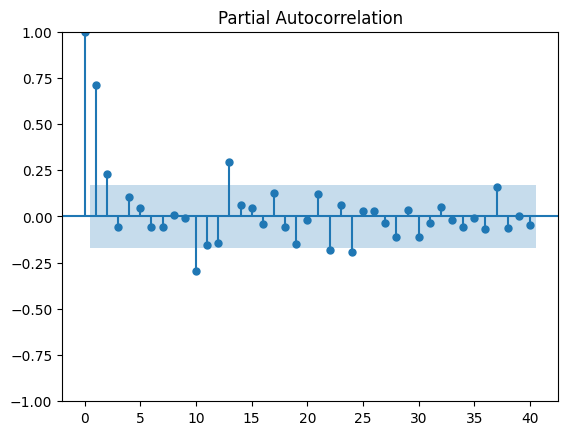

In [21]:
lnair12 = data['lnair12'].dropna()

print('Airline Passenger Load - Seasonal Differencing')
plot_acf(lnair12.dropna(), lags = 40);
plot_pacf(lnair12.dropna(), method = 'ywm', lags = 40);

In [26]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['10%']

    if (pvalue < 0.1) and (adf < critical_value): ### as statsmodel adfuller p-value is not as accurate
        print('The series is stationary, reject null as 10% significance level')
    else:
        print('The series is NOT stationary, do not reject null at 10% signifcance level')

In [27]:
print('ADF Statistic: %f' % adfuller(lnair12)[0])
print('pvalue: %f' % adfuller(lnair12)[1])
check_stationarity(lnair12)

ADF Statistic: -2.709577
pvalue: 0.072396
The series is stationary, reject null as 10% significance level


Documentation for an example of 
statsmodels.tsa.statespace.sarimax.SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, concentrate_scale=False, trend_offset=1, use_exact_diffuse=False, dates=None, freq=None, missing='none', validate_specification=True, **kwargs)

In [30]:
### apply (1,0,1)*(0,1,0)_12
import statsmodels.api as sm
model0 = sm.tsa.statespace.SARIMAX(data['lnair'], order=(1,0,1), seasonal_order=(0,1,0, 12))
model0_fit = model0.fit(disp = 0)
model0_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               lnair   No. Observations:                  144
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                 228.678
Date:                             Wed, 24 Jan 2024   AIC                           -451.355
Time:                                     17:10:09   BIC                           -442.707
Sample:                                          0   HQIC                          -447.841
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9768      0.017     56.234      0.000       0.943       1.011
ma.L1         -0.3739      0.075     -4.953      0.000      -0.522      -0.226
sigma2         0.0018      0.000      9.272      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.70
Prob(Q):                              1.00   Prob(JB):                         0.16
Heteroskedasticity (H):               0.40   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
### Apply (1,0,1) directly to lnair12 -- avoid initial 12 obs null in fitting later
### Results slightly diff cos internally treating NA in first 12 obs is a bit different
import statsmodels.api as sm
model1 = sm.tsa.statespace.SARIMAX(data['lnair12'], trend='c', order=(1,0,1))  
model1_fit=model1.fit(disp=0)
print(model1_fit.summary())
### constant c is added

                               SARIMAX Results                                
Dep. Variable:                lnair12   No. Observations:                  144
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 232.589
Date:                Wed, 24 Jan 2024   AIC                           -457.177
Time:                        17:11:31   BIC                           -445.298
Sample:                             0   HQIC                          -452.350
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0164      0.007      2.261      0.024       0.002       0.031
ar.L1          0.8569      0.057     15.035      0.000       0.745       0.969
ma.L1         -0.2848      0.103     -2.767      0.0

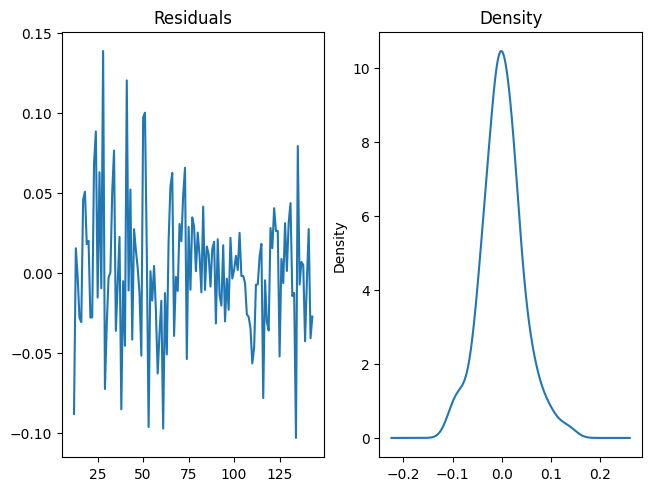

In [32]:
### Plot residual errors
### See https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
residuals1 = model1_fit.resid
fig,ax = plt.subplots(1,2,constrained_layout = True)
residuals1.plot(title="Residuals", ax=ax[0])
residuals1.plot(kind='kde',title='Density',ax=ax[1])
plt.show()
##resi=pd.DataFrame(model1_fit.resid)  ### convert back to pandas df

In [40]:
predictions1 = model1.fit().predict()  ### Note: 'predict' is just fitting here
print(predictions1)
err1=abs(predictions1-lnair12.dropna())
print(err1.dropna())
err1na=err1.dropna()
print("mean abs error =", np.sum(err1na)/err1na.size)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60955D+00    |proj g|=  1.98088D+00

At iterate    5    f= -1.61182D+00    |proj g|=  3.31477D-01

At iterate   10    f= -1.61278D+00    |proj g|=  2.46168D-01

At iterate   15    f= -1.61419D+00    |proj g|=  9.05744D-01

At iterate   20    f= -1.61520D+00    |proj g|=  4.00992D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     43      1     0     0   5.676D-04  -1.615D+00
  F =  -1.6151993029385407     

CONVERG

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


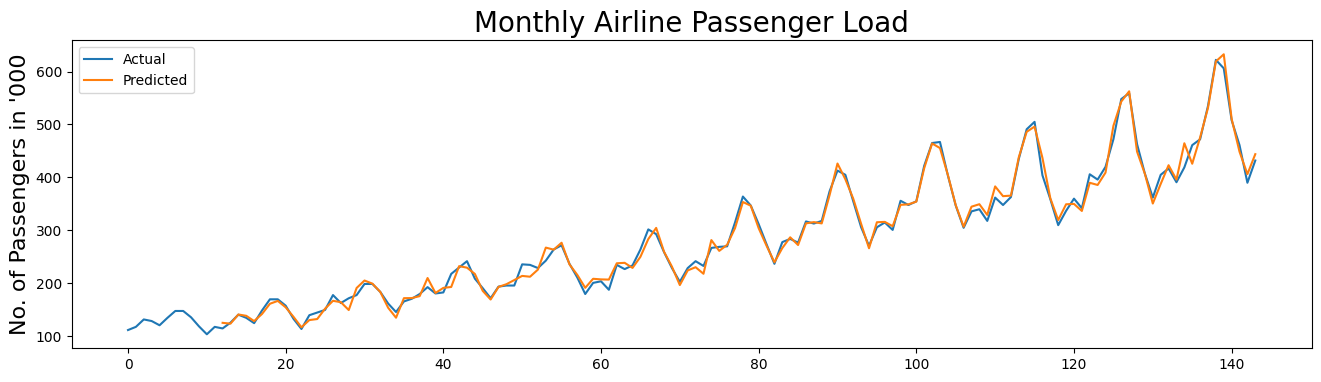

In [41]:
predict1=predictions1 + data['lnair'].shift(12)
## convert ln back to raw levels
Epredict1=np.exp(predict1)
plt.figure(figsize=(16,4))
plt.plot(data['Passengers'], label="Actual")
plt.plot(Epredict1, label="Predicted")
plt.title('Monthly Airline Passenger Load', fontsize=20)
plt.ylabel("No. of Passengers in '000", fontsize=16)
plt.legend()

# Now we try other specifications of ARIMA

In [42]:
### Apply (1,0,6) directly to lnair12 -- avoid initial 12 obs null in fitting later
### Results slightly diff cos of 144 vs 132, treating of starting value
import statsmodels.api as sm
model2 = sm.tsa.statespace.SARIMAX(data['lnair12'], trend='c', order=(1,0,6))  
model2_fit=model2.fit(disp=0,maxiter=250)  ## incr maxiter avoids 'nonconverg of ML'
print(model2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                lnair12   No. Observations:                  144
Model:               SARIMAX(1, 0, 6)   Log Likelihood                 238.866
Date:                Wed, 24 Jan 2024   AIC                           -459.732
Time:                        17:21:36   BIC                           -433.004
Sample:                             0   HQIC                          -448.871
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0254      0.011      2.220      0.026       0.003       0.048
ar.L1          0.7772      0.085      9.190      0.000       0.611       0.943
ma.L1         -0.2518      0.105     -2.404      0.0

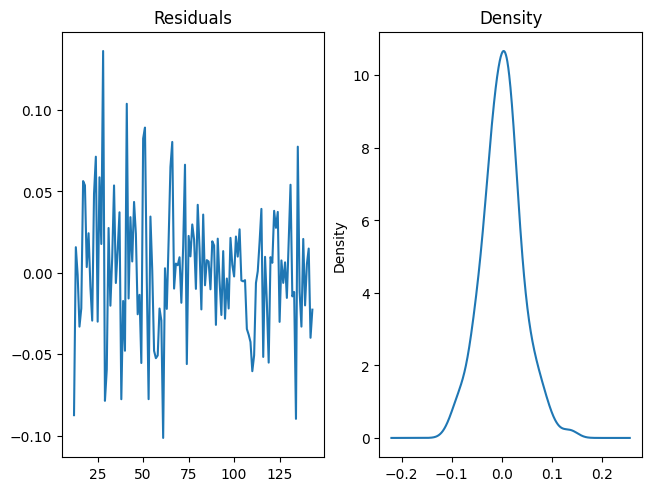

In [43]:
### Plot residual errors
residuals2 = model2_fit.resid
fig,ax = plt.subplots(1,2,constrained_layout = True)
residuals2.plot(title="Residuals", ax=ax[0])
residuals2.plot(kind='kde',title='Density',ax=ax[1])
plt.show()

In [44]:
predictions2 = model2.fit().predict()  ### Note: 'predict' is just fitting here
pd.set_option('display.max_rows', None)  ### print without truncation
print(predictions2)
err2=abs(predictions2-lnair12.dropna())
print(err2.dropna())
err2na=err2.dropna()
print("mean abs error =", np.sum(err2na)/err2na.size)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63614D+00    |proj g|=  2.99689D+00

At iterate    5    f= -1.64031D+00    |proj g|=  4.19673D-01

At iterate   10    f= -1.65045D+00    |proj g|=  2.47496D-01

At iterate   15    f= -1.65136D+00    |proj g|=  4.57588D-01

At iterate   20    f= -1.65594D+00    |proj g|=  1.58978D-01

At iterate   25    f= -1.65764D+00    |proj g|=  7.23702D-01

At iterate   30    f= -1.65816D+00    |proj g|=  9.58542D-02

At iterate   35    f= -1.65840D+00    |proj g|=  1.76414D-01

At iterate   40    f= -1.65847D+00    |proj g|=  1.01620D-02


 This problem is unconstrained.



At iterate   45    f= -1.65849D+00    |proj g|=  6.26665D-02

At iterate   50    f= -1.65866D+00    |proj g|=  3.32726D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   3.327D-02  -1.659D+00
  F =  -1.6586588068343942     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
0      0.113851
1      0.113851
2      0.113851
3      0.113851
4      0.113851
5      0.113851
6      0.113851
7      0.113851
8      0.113851
9      0.113851
10     0.113851
11     0.113851
12     0.113851
13     0.050689
14     0.067921
15     0.078988
16     0.054665
17     0.042995
18     0.08

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


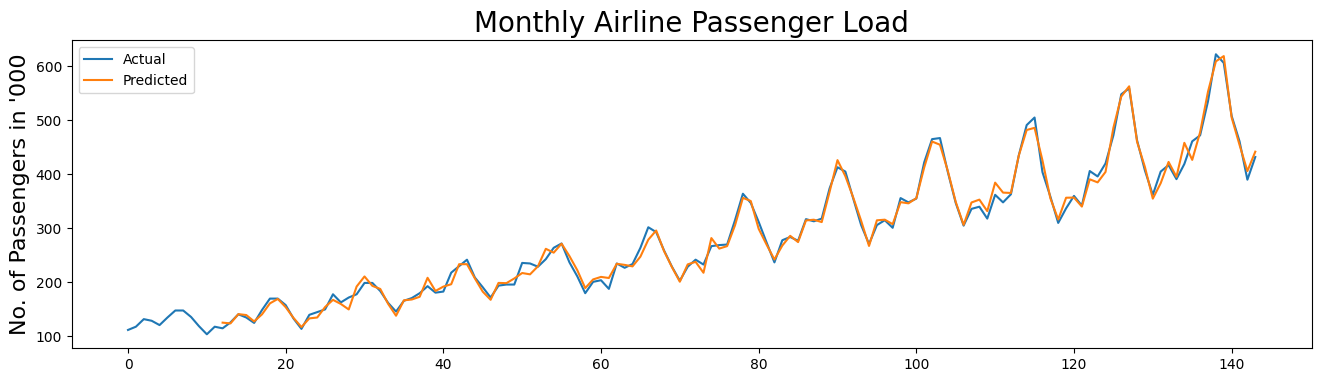

In [45]:
predict2=predictions2 + data['lnair'].shift(12)
## convert ln back to raw levels
Epredict2=np.exp(predict2)
plt.figure(figsize=(16,4))
plt.plot(data['Passengers'], label="Actual")
plt.plot(Epredict2, label="Predicted")
plt.title('Monthly Airline Passenger Load', fontsize=20)
plt.ylabel("No. of Passengers in '000", fontsize=16)
plt.legend()

# Try 1-month ahead prediction

In [46]:
print(model2_fit.params)

intercept    0.025377
ar.L1        0.777179
ma.L1       -0.251765
ma.L2        0.134588
ma.L3       -0.173481
ma.L4        0.042890
ma.L5        0.169536
ma.L6        0.300084
sigma2       0.001546
dtype: float64



When you set dynamic=True, the model continuously predicts one-step ahead (t+1) and then for the 2nd step ahead (t+2) prediction, it appends predicted value (t+1) to data, re-fits model on new expanded data then makes 2nd step ahead forecast. This is called out-of-sample prediction using predicted explanatory variables

When you set dynamic=False, the model sequentially predicts one-step-ahead using the true value from previous time step instead of using predicted value. This is called out-of-sample prediction using lagged explanatory variables

In [47]:
s=model2_fit.predict(start=0, end=150, exog=None, dynamic=False)
print(s)

0      0.113888
1      0.113888
2      0.113888
3      0.113888
4      0.113888
5      0.113888
6      0.113888
7      0.113888
8      0.113888
9      0.113888
10     0.113888
11     0.113888
12     0.113888
13     0.049842
14     0.067206
15     0.078520
16     0.054290
17     0.042289
18     0.084813
19     0.135036
20     0.125610
21     0.119560
22     0.121166
23     0.122414
24     0.160442
25     0.204354
26     0.174334
27     0.170746
28     0.182881
29     0.256488
30     0.216996
31     0.129966
32     0.172535
33     0.187589
34     0.193712
35     0.176588
36     0.150882
37     0.145123
38     0.158571
39     0.122048
40     0.109864
41     0.098836
42     0.160538
43     0.161421
44     0.120404
45     0.121118
46     0.139968
47     0.181334
48     0.149955
49     0.140561
50     0.118611
51     0.171842
52     0.228824
53     0.186192
54     0.103289
55     0.115360
56     0.173640
57     0.152028
58     0.096212
59     0.057373
60     0.069290
61     0.059773
62    -0